## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.data import find

In [2]:
def download_nltk_resources():
    resources = ['all']
    for resource in resources:
        try:
            find(f'tokenizers/{resource}')
        except LookupError:
            nltk.download(resource)

download_nltk_resources()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\uif93590\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\uif93590\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\uif93590\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\uif93590\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\uif93590\AppData\Roaming

## Import the dataset

In [3]:
project_dir = os.path.dirname(os.getcwd())
dataset_path = os.path.join(project_dir, "data", "raw", "Combined Data.csv")

In [4]:
df = pd.read_csv(dataset_path)
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


## EDA

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None


In [6]:
print(df.describe())

         Unnamed: 0
count  53043.000000
mean   26521.000000
std    15312.339501
min        0.000000
25%    13260.500000
50%    26521.000000
75%    39781.500000
max    53042.000000


Remove missing data

In [7]:
df.isna().sum()

Unnamed: 0      0
statement     362
status          0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isna().sum()

Unnamed: 0    0
statement     0
status        0
dtype: int64

In [10]:
df['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

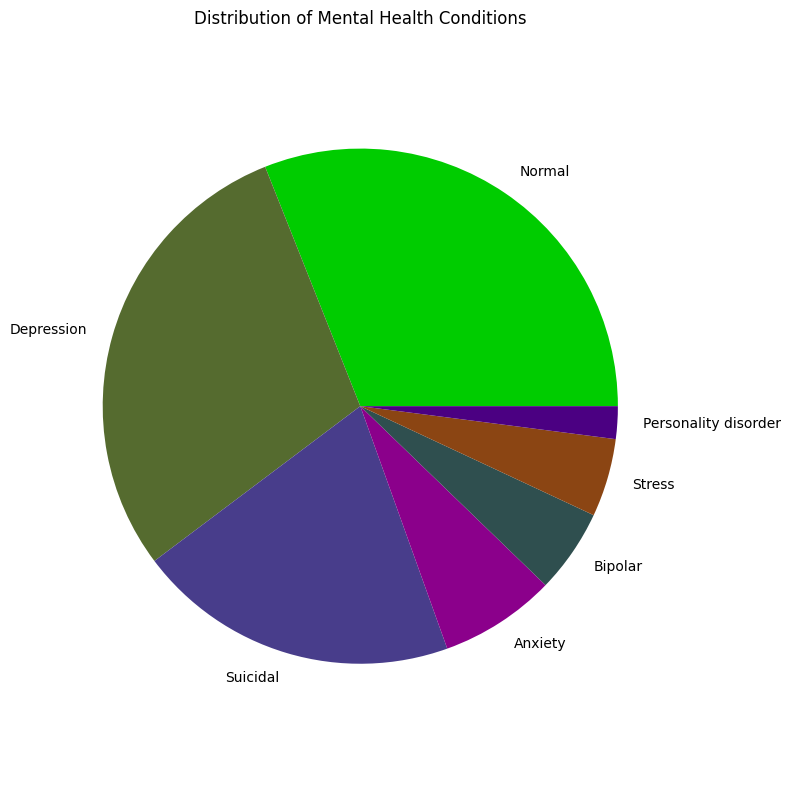

In [11]:
status_counts = df['status'].value_counts()

colors = ['#00CC00', '#556B2F', '#483D8B', '#8B008B', '#2F4F4F', '#8B4513', '#4B0082']

plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, colors=colors)

plt.title("Distribution of Mental Health Conditions")
plt.axis('equal')

plt.tight_layout()
plt.show()


Check out texts. 
Group by status.

In [12]:
unique_statuses = df['status'].unique()
for status in unique_statuses:
    statement = df[df['status'] == status]['statement'].iloc[0]
    print(f"Status:{status}\nStatement: {statement}\n")

Status:Anxiety
Statement: oh my gosh

Status:Normal
Statement: Gr gr dreaming of ex crush to be my game, God

Status:Depression
Statement: I recently went through a breakup and she said she still wants to be friends so I said I can try doing that but when she talks to me about things it always hurts. I just want to lose feelings so all this pain can stop it hurts so much and I cannot even cry about it. I do not want to hurt her because she said she does not want to never speak to me again but I do not know what to do here. When we were together she always hurt me so I do not know why I still love her. I wish we never met it would be much less painful How do I lose feelings?

Status:Suicidal
Statement: I am so exhausted of this. Just when I think I can finally rest, just when I think maybe things are starting to settle, another hurdle comes flying at me. This month alone we found out my mum could be dying, my girlfriend left me, my parents revealed that they wanted a divorce, my grandad

Add number of characters and sentences to the df.

In [13]:
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))
print(df)

       Unnamed: 0                                          statement   status  \
0               0                                         oh my gosh  Anxiety   
1               1  trouble sleeping, confused mind, restless hear...  Anxiety   
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3               3  I've shifted my focus to something else but I'...  Anxiety   
4               4  I'm restless and restless, it's been a month n...  Anxiety   
...           ...                                                ...      ...   
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety   
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety   
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety   
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety   
53042       53042  I have really bad door anxiety! It's not about...  Anxiety   

       num_of_characters  n

## Text preprocessing

* Convert text to lowercase
* Remove special characters, punctuation, and numbers
* Tokenization (splitting sentences into words)
* Stopword removal (removing common words like "the", "and", "is")
* Lemmatization or stemming (reducing words to their base form)

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [15]:
df['cleaned_statement'] = df['statement'].apply(clean_text)

In [19]:
empty_string_count = df['cleaned_statement'].apply(lambda x: x == '').sum()
print(f"Number of empty string values: {empty_string_count}")

Number of empty string values: 131


In [20]:
df = df[df['cleaned_statement'] != '']

Save the cleaned dataset.

In [21]:
df.to_csv(os.path.join(project_dir, 'data', 'processed', 'processed_data.csv'))

Data preprocessing finished. Continue working in another notebook.